1-预处理数据：《数据融合》


2-基于余弦相似度:构建《相似度约束函数》。实验以证明，其具有2点性质：（1）同类相似度最大化；（2）异类相似度最小化；


3-把上述《相似度约束函数》应用于滚动轴承故障识别，以证明其可以提高《准确率》

In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import time

print(tf.__version__)

gpus = tf.config.list_physical_devices(device_type='GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
except:
    print('Error!')
    pass

2.6.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import time
def get_date():
    now_time = list(time.localtime(time.time()))
    date = '_TIME'
    for i,item in enumerate(time.localtime(time.time())):
        date = date + '_' + str(item)
        if i==2:
            date = date + '__'
        if i==4:
            date = date + '__'
        if i > 5: break
    return date
get_date()

'_TIME_2022_1_18___13_4___0_1'

# 加载数据

In [3]:
dp = 'F:\\Data\\PHME16'
all_bearing_names = os.listdir(dp)
print(all_bearing_names)

normal_bearings = ['K001','K002','K003','K004','K005']
outer_bearings  = ['KA04','KA15','KA16','KA22','KA30']
inner_bearings  = ['KI04','KI14','KI16','KI18','KI21']

# normal_bearings = ['K001']
# outer_bearings  = ['KA04']
# inner_bearings  = ['KI04']

def find_exist_bearings(bearings):
    exist_bearings = []
    for name in all_bearing_names:
        if name in bearings:
            exist_bearings.append(name)
    return exist_bearings
find_exist_bearings(normal_bearings), find_exist_bearings(outer_bearings), find_exist_bearings(inner_bearings) 

['20160703_PHME16_CM_bearing.pdf', 'csv', 'data_structure.m', 'desktop.ini', 'K001', 'K002', 'K003', 'K004', 'K005', 'KA01', 'KA03', 'KA04', 'KA15', 'KA16', 'KA22', 'KA30', 'KB23', 'KB24', 'KB27', 'KI01', 'KI04', 'KI14', 'KI16', 'KI18', 'KI21', 'matlab-画图.docx', 'wode.docx', '~$tlab-画图.docx', '压缩包']


(['K001', 'K002', 'K003', 'K004', 'K005'],
 ['KA04', 'KA15', 'KA16', 'KA22', 'KA30'],
 ['KI04', 'KI14', 'KI16', 'KI18', 'KI21'])

工况共有4种：

A：N15_M01_F10

B：N09_M07_F10

C：N15_M07_F04

D：N15_M07_F10

In [4]:
def find_mat_names(bearing):
    mat_names = []
    bearing_path = dp + '\\' +bearing
    all_names = os.listdir(bearing_path)
    for name in all_names:
        if 'mat' in name:
            #  N15_M01_F10,  N09_M07_F10,  N15_M07_F04,  N15_M07_F10
            if 'N15_M01_F10'  in name:
                mat_names.append(name)
    return bearing_path, mat_names

bearing_path, mat_names = find_mat_names('K001')
bearing_path, len(mat_names),mat_names[::10]

('F:\\Data\\PHME16\\K001',
 20,
 ['N15_M01_F10_K001_1.mat', 'N15_M01_F10_K001_19.mat'])

In [5]:
def load_mat(bearing_path,mat_name):
    mat_path = bearing_path + '\\' + mat_name
    print(mat_path)
    mat = scipy.io.loadmat(mat_path)
    return mat


La = 4*64000
L = 80*80
num = La//L
print(La,L,num,num*L)

256000 6400 40 256000


In [6]:
num = 10

def parse_mat(mat):
    '''输入mat，返回c1,c2,v，
    采样频率64KHz，采样时间4S，因此应该有64K*4个数据点,
     每个C1、C2、V都是以64K的采样率，采样4秒，故采样点数4*64K
    按照每个样本长度=1.5圈*4266点/圈，约6400点划分样本，得40个样本'''
    for key in mat.keys():
        if 'K' in key:
            datakey = key
    matdata = mat[datakey][0][0]
    [info,X,Y,Desc] = matdata
    [info,X,Y,Desc] = [x[0] for x in [info,X,Y,Desc]]
    c1 = Y[1][2].reshape(-1) / 3.0
    c2 = Y[2][2].reshape(-1) / 3.0
    v  = Y[6][2].reshape(-1) / 10.0
    c1c2v = np.stack([c1,c2,v],axis=-1)
    
    s = 0
    c1c2v = c1c2v[s:s+num*L,:]
    c1c2v = c1c2v.reshape(-1,80*80,3)
    return c1c2v

In [7]:
def get_c1_c2_v_of_one_type(bearings):
    '''bearings = normal_bearings/outer_bearings/inner_bearings'''
    c1c2v_samples = []
    for bearing in bearings:
        '''一类轴承中的某一个轴承，如所有外圈故障轴承中的KA04'''
        bearing_path, mat_names = find_mat_names(bearing)
        print(bearing_path,'contain', len(mat_names), 'mat file',sep = '  ')
        for mat_name in mat_names:
            '''某个轴承在4种不同工况各有20次实验，取4*20个实验中的某一个实验采集到的mat'''
            mat = load_mat(bearing_path,mat_name)
            c1c2v = parse_mat(mat)
            c1c2v_samples.append(c1c2v)
        
        print('One bearing mat files has been read.','\n\n')
    data = np.concatenate(c1c2v_samples)
    return data

normal_data_128 = get_c1_c2_v_of_one_type(normal_bearings)
outer_data_128 = get_c1_c2_v_of_one_type(outer_bearings)
inner_data_128 = get_c1_c2_v_of_one_type(inner_bearings)

F:\Data\PHME16\K001  contain  20  mat file
F:\Data\PHME16\K001\N15_M01_F10_K001_1.mat
F:\Data\PHME16\K001\N15_M01_F10_K001_10.mat
F:\Data\PHME16\K001\N15_M01_F10_K001_11.mat
F:\Data\PHME16\K001\N15_M01_F10_K001_12.mat
F:\Data\PHME16\K001\N15_M01_F10_K001_13.mat
F:\Data\PHME16\K001\N15_M01_F10_K001_14.mat
F:\Data\PHME16\K001\N15_M01_F10_K001_15.mat
F:\Data\PHME16\K001\N15_M01_F10_K001_16.mat
F:\Data\PHME16\K001\N15_M01_F10_K001_17.mat
F:\Data\PHME16\K001\N15_M01_F10_K001_18.mat
F:\Data\PHME16\K001\N15_M01_F10_K001_19.mat
F:\Data\PHME16\K001\N15_M01_F10_K001_2.mat
F:\Data\PHME16\K001\N15_M01_F10_K001_20.mat
F:\Data\PHME16\K001\N15_M01_F10_K001_3.mat
F:\Data\PHME16\K001\N15_M01_F10_K001_4.mat
F:\Data\PHME16\K001\N15_M01_F10_K001_5.mat
F:\Data\PHME16\K001\N15_M01_F10_K001_6.mat
F:\Data\PHME16\K001\N15_M01_F10_K001_7.mat
F:\Data\PHME16\K001\N15_M01_F10_K001_8.mat
F:\Data\PHME16\K001\N15_M01_F10_K001_9.mat
One bearing mat files has been read. 


F:\Data\PHME16\K002  contain  20  mat file
F:\

F:\Data\PHME16\KA30\N15_M01_F10_KA30_16.mat
F:\Data\PHME16\KA30\N15_M01_F10_KA30_17.mat
F:\Data\PHME16\KA30\N15_M01_F10_KA30_18.mat
F:\Data\PHME16\KA30\N15_M01_F10_KA30_19.mat
F:\Data\PHME16\KA30\N15_M01_F10_KA30_2.mat
F:\Data\PHME16\KA30\N15_M01_F10_KA30_20.mat
F:\Data\PHME16\KA30\N15_M01_F10_KA30_3.mat
F:\Data\PHME16\KA30\N15_M01_F10_KA30_4.mat
F:\Data\PHME16\KA30\N15_M01_F10_KA30_5.mat
F:\Data\PHME16\KA30\N15_M01_F10_KA30_6.mat
F:\Data\PHME16\KA30\N15_M01_F10_KA30_7.mat
F:\Data\PHME16\KA30\N15_M01_F10_KA30_8.mat
F:\Data\PHME16\KA30\N15_M01_F10_KA30_9.mat
One bearing mat files has been read. 


F:\Data\PHME16\KI04  contain  20  mat file
F:\Data\PHME16\KI04\N15_M01_F10_KI04_1.mat
F:\Data\PHME16\KI04\N15_M01_F10_KI04_10.mat
F:\Data\PHME16\KI04\N15_M01_F10_KI04_11.mat
F:\Data\PHME16\KI04\N15_M01_F10_KI04_12.mat
F:\Data\PHME16\KI04\N15_M01_F10_KI04_13.mat
F:\Data\PHME16\KI04\N15_M01_F10_KI04_14.mat
F:\Data\PHME16\KI04\N15_M01_F10_KI04_15.mat
F:\Data\PHME16\KI04\N15_M01_F10_KI04_16.mat
F:

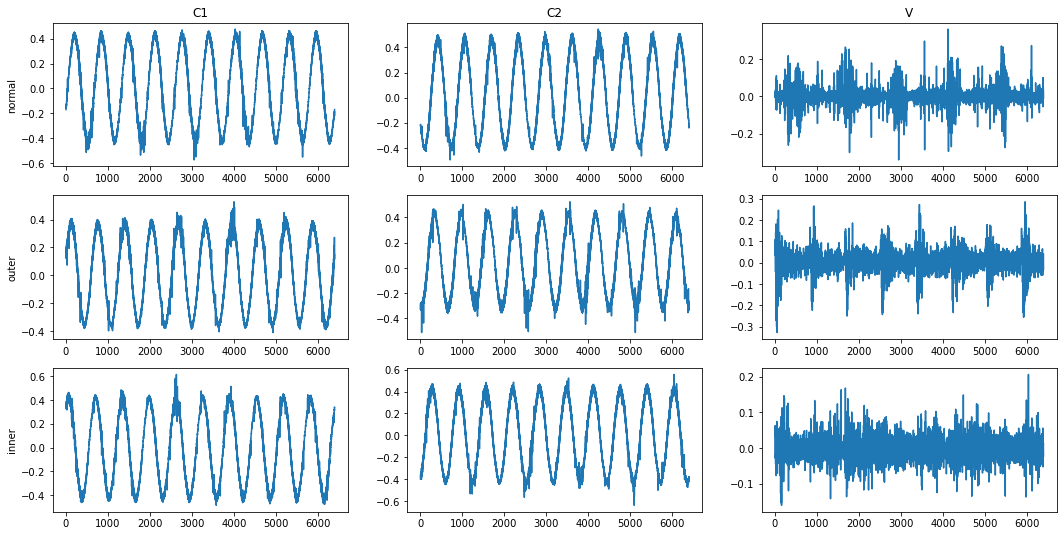

In [8]:
kn = 23
ko = 2
ki = 53
plt.figure(figsize=(18,9))
plt.subplot(331)
plt.plot(normal_data_128[kn,:,0])
plt.ylabel('normal')
plt.title('C1')
plt.subplot(332)
plt.plot(normal_data_128[kn,:,1])
plt.title('C2')
plt.subplot(333)
plt.plot(normal_data_128[kn,:,2])
plt.title('V')

plt.subplot(334)
plt.plot(outer_data_128[ko,:,0])
plt.ylabel('outer')
plt.subplot(335)
plt.plot(outer_data_128[ko,:,1])
plt.subplot(336)
plt.plot(outer_data_128[ko,:,2])

plt.subplot(337)
plt.plot(inner_data_128[ki,:,0])
plt.ylabel('inner')
plt.subplot(338)
plt.plot(inner_data_128[ki,:,1])
plt.subplot(339)
plt.plot(inner_data_128[ki,:,2])
plt.show()

# 构建数据集

In [9]:
start = time.time()
time.sleep(0.5)
end = time.time()
start,end,end-start

(1642482258.594077, 1642482259.1057525, 0.5116753578186035)

In [10]:

print(np.random.random())
np.random.seed(2021)
print(np.random.random())

np.random.seed(2)
print(np.random.random())
np.random.seed(2)
print(np.random.random())


0.69157351988065
0.6059782788074047
0.43599490214200376
0.43599490214200376


In [11]:
'''
状态（3），轴承（5），工况（4），mat（20），样本（40）
所有样本：3*5*4*20*40=48000
一种状态：1*5*4*20*40=16000
一种工况：3*5*1*20*40=12000
'''
M = 80
normal_data = normal_data_128[:,:M*M,:]
outer_data  = outer_data_128[:,:M*M,:]
inner_data  = inner_data_128[:,:M*M,:]

np.random.seed(seed=None)

def get_ds(bs = 30, m=80, tra_rate=0.8  ):
    '''截取固定长度的信号'''
    window_size = m**2
    print('window_size:  ',window_size)
    normal_data = normal_data_128[:,:window_size,:]
    outer_data  = outer_data_128[:, :window_size,:]
    inner_data  = inner_data_128[:, :window_size,:]
    
    all_data  = np.concatenate([normal_data, outer_data, inner_data])
    all_labels = np.array([0]*len(normal_data) + [1]*len(outer_data) + [2]*len(inner_data))
    print('all_data : ',all_data.shape,all_labels[::500])

    '''样本划分'''
    indexes = np.arange(len(all_data))
    np.random.shuffle(indexes)
    split_num = int(tra_rate*len(all_data))
    
    tra_data   = all_data[indexes[:split_num]]
    tra_labels = all_labels[indexes[:split_num]]
    
    tes_data   = all_data[indexes[split_num:]]
    tes_labels = all_labels[indexes[split_num:]]
    
    print('tra : tes =',len(tra_labels), len(tes_data),sep='\t')
    print(tra_labels[::300],tes_labels[::300])
    
    BUFFER = len(all_data)
    tra_ds = tf.data.Dataset.from_tensor_slices((tra_data,tra_labels)).repeat().shuffle(BUFFER).batch(bs).prefetch(2)
    tes_ds = tf.data.Dataset.from_tensor_slices((tes_data,tes_labels)).repeat().shuffle(BUFFER).batch(bs).prefetch(2)
        
    tra_tes_num = [len(tra_labels),len(tes_data)]
    print('Dataset 准备好了!!!\n')
    return tra_ds,tes_ds, tra_tes_num


tra_ds,tes_ds, tra_tes_num = get_ds( bs = 30, m=M, tra_rate=0.8)


window_size:   6400
all_data :  (3000, 6400, 3) [0 0 1 1 2 2]
tra : tes =	2400	600
[1 2 2 1 0 2 0 2] [0 1]
Dataset 准备好了!!!



In [12]:
tra_tes_num

[2400, 600]

In [13]:
for i,(batch_X,batch_Y) in enumerate(tra_ds):
    print('tra_ds',batch_X.shape,batch_Y.numpy())
    break
    
for i,(X,Y) in enumerate(tra_ds):
    print('tes_ds',X.shape,Y.numpy())
    break


tra_ds (30, 6400, 3) [2 1 1 1 2 1 2 0 1 1 1 0 1 1 1 0 0 2 1 0 1 1 1 2 2 1 0 2 2 0]
tes_ds (30, 6400, 3) [0 0 2 2 0 2 1 0 0 0 0 0 1 1 0 1 1 1 0 0 2 0 2 1 0 2 0 0 0 0]


0 (30, 6400, 3) (30,) [2 1 2 1 2 1 2 2 2 2 2 0 1 2 0 1 1 2 0 2 2 1 1 2 1 2 0 1 0 1]


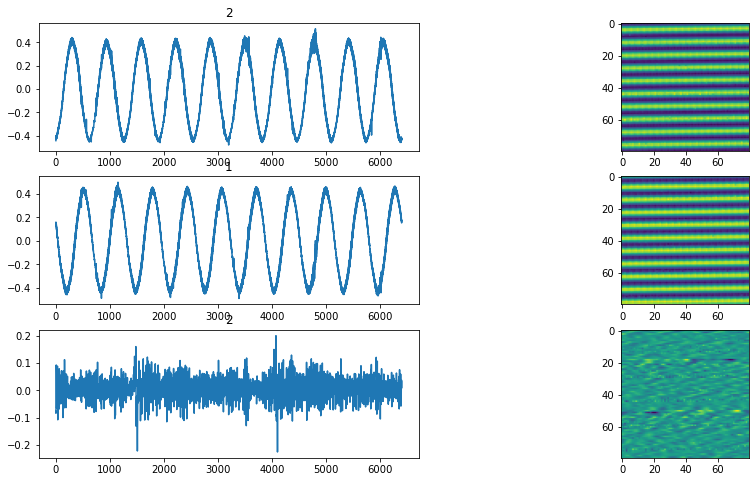

In [14]:
m = 80
for i,(X,Y) in enumerate(tra_ds):
    print(i,X.shape,Y.shape,Y.numpy())
    plt.figure(figsize=(15,8))
    for j in range(3):
        plt.subplot(3,2,2*j+1)
        plt.plot(X[0,:,j])
        plt.title(str(Y[j].numpy()))
        plt.subplot(3,2,2*j+2)
        img = X[0,:,j].numpy().reshape(m,m)
        plt.imshow(img)
    break

# 构建 CNN模型

In [15]:
L = tf.keras.regularizers.L2()
L = None

def Feature_Exacter():
    inputs = tf.keras.Input(shape=  (M*M, 3) , name='inputs')
    x1 = inputs[:,:,:2]
    m = M
    x1  = tf.keras.layers.Reshape((m,m,-1))(x1)
    
    f = [5,10,15,30]
    k = [9,7,5,3]
    s = [1,1,1,1]
    
#     print('inputs,inputs1,inputs2',inputs.shape,inputs1.shape,inputs2.shape)
    ##############################################################################################################
    x1 = tf.keras.layers.Conv2D(f[0],k[0],s[0],activation='relu',padding='same',kernel_regularizer=L,name='x1c1')(x1)
    x1 = tf.keras.layers.MaxPool2D(name='x1p1')(x1)
    
    x1 = tf.keras.layers.Conv2D(f[1],k[1],s[1],activation='relu',padding='same',kernel_regularizer=L,name='x1c2')(x1)
    x1 = tf.keras.layers.MaxPool2D(name='x1p2')(x1)
    
    x1 = tf.keras.layers.Conv2D(f[2],k[2],s[2],activation='relu',padding='same',kernel_regularizer=L,name='x1c3')(x1)
    x1 = tf.keras.layers.MaxPool2D(name='x1p3')(x1)
    
    x1 = tf.keras.layers.Conv2D(f[3],k[3],s[3],activation='relu',padding='same',kernel_regularizer=L,name='x1c4')(x1)
    x1 = tf.keras.layers.MaxPool2D(name='x1p4')(x1)
    
#     x1 = tf.keras.layers.Conv2D(f[4],k[4],s[4],activation='relu',padding='same',kernel_regularizer=L,name='x1c5')(x1)
#     x1 = tf.keras.layers.MaxPool2D(name='x1p5')(x1)
    
    x1 = tf.keras.layers.Flatten(name='Flatten')(x1)
    x1 = tf.keras.layers.Dropout(0.5)(x1)
    model = tf.keras.Model(inputs=inputs, outputs=x1, name='FE')
    return model
FEModel = Feature_Exacter()
FEModel.summary()


# def Header():
#     inputs = tf.keras.Input(shape=(128,),name='inputs')
#     x = tf.keras.layers.Dense(128,activation='sigmoid',name='dense_1')(inputs)
#     x = tf.keras.layers.Dropout(0.2)(x)
#     outputs = tf.keras.layers.Dense(128,activation=None,name='dense_2')(x)
#     model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Header')
#     return model
# HModel = Header()
# HModel.summary()


def Clssfier():
    inputs = tf.keras.Input(shape=(750,),name='inputs')
#     x = tf.keras.layers.Dense(128,activation='relu',name='dense')(inputs)
#     x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(3,activation='softmax',name='softmax')(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=x, name='FE')
    return model
CModel = Clssfier()
CModel.summary()

Model: "FE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 6400, 3)]         0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 6400, 2)           0         
_________________________________________________________________
reshape (Reshape)            (None, 80, 80, 2)         0         
_________________________________________________________________
x1c1 (Conv2D)                (None, 80, 80, 5)         815       
_________________________________________________________________
x1p1 (MaxPooling2D)          (None, 40, 40, 5)         0         
_________________________________________________________________
x1c2 (Conv2D)                (None, 40, 40, 10)        2460      
_________________________________________________________________
x1p2 (MaxPooling2D)          (None, 20, 20, 10)        0        

# 训练

[410 852 443]


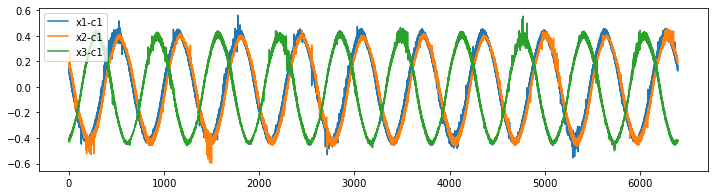

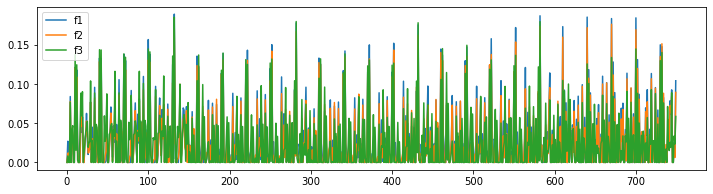

Sim11 [1.         1.         0.99999994 0.9999999  1.         1.
 1.         1.         1.         1.         0.9999999  0.99999994
 0.99999994 1.0000001  1.         1.0000001  1.         1.
 1.0000001  1.         0.9999999  0.99999994 1.         0.99999994
 1.         1.         0.9999998  0.9999999  1.         1.0000001 ]
Sim12 [0.98940617 0.9920831  0.9933531  0.99524784 0.99658275 0.99654573
 0.99740195 0.99702704 0.9967205  0.99651384 0.92326397 0.9196193
 0.9155847  0.9092302  0.9054781  0.8990038  0.8911223  0.88475823
 0.882762   0.8723079  0.8631638  0.87183774 0.88968146 0.9001678
 0.911972   0.9186617  0.91790533 0.9205142  0.92266333 0.9214245 ]


In [16]:
k = np.random.randint(0,1000,size=(3,))
print(k)
s = 30
sample1 = normal_data[k[0]:k[0]+s]
sample2 = outer_data[k[0]:k[0]+s]
sample3 = inner_data[k[0]:k[0]+s]

plt.figure(figsize=(12,3))
plt.plot(sample1[0,:,0],label='x1-c1')
plt.plot(sample2[0,:,0],label='x2-c1')
plt.plot(sample3[0,:,0],label='x3-c1')
plt.legend()
plt.show()

f1 = FEModel(sample1)
f2 = FEModel(sample2)
f3 = FEModel(sample3)

# h1 = HModel(f1)
# h2 = HModel(f2)
# h3 = HModel(f3)


plt.figure(figsize=(12,3))
plt.plot(f1.numpy()[0],label='f1')
plt.plot(f2.numpy()[0],label='f2')
plt.plot(f3.numpy()[0],label='f3')
plt.legend()
plt.show()

# plt.figure(figsize=(12,3))
# plt.plot(h1.numpy()[0],label='h1')
# plt.plot(h2.numpy()[0],label='h2')
# plt.plot(h3.numpy()[0],label='h3')
# plt.legend()
# plt.show()

def CosSim(y,p):
    '''y和p=（N,L）=(样本数，特征长度)，返回N对（y，p）的相似度'''
    y = tf.math.l2_normalize(y,axis = -1)         # [样本数，特征数]
    p = tf.math.l2_normalize(p,axis = -1)         # [样本数，特征数]
    y_p = tf.math.multiply(y, p)                  # [样本数，特征数]
    cossim = tf.math.reduce_sum(y_p, axis = -1)   # [样本数，]
    return cossim
print('Sim11',CosSim(f1,f1).numpy())
print('Sim12',CosSim(f1,f2).numpy())

# print('Sim11',CosSim(h1,h1).numpy())
# print('Sim12',CosSim(h1,h2).numpy())

In [17]:
def CosSim(y,p):
    '''y和p=（N,L）=(样本数，特征长度)，返回N对（y，p）的相似度'''
    y = tf.math.l2_normalize(y,axis = -1)         # [样本数，特征数]
    p = tf.math.l2_normalize(p,axis = -1)         # [样本数，特征数]
    y_p = tf.math.multiply(y, p)                  # [样本数，特征数]
    cossim = tf.math.reduce_sum(y_p, axis = -1)   # [样本数，]
    return cossim
print('Sim11',CosSim(f1,f1).numpy())
print('Sim12',CosSim(f1,f2).numpy())

# print('Sim11',CosSim(h1,h1).numpy())
# print('Sim12',CosSim(h1,h2).numpy())

Sim11 [1.         1.         0.99999994 0.9999999  1.         1.
 1.         1.         1.         1.         0.9999999  0.99999994
 0.99999994 1.0000001  1.         1.0000001  1.         1.
 1.0000001  1.         0.9999999  0.99999994 1.         0.99999994
 1.         1.         0.9999998  0.9999999  1.         1.0000001 ]
Sim12 [0.98940617 0.9920831  0.9933531  0.99524784 0.99658275 0.99654573
 0.99740195 0.99702704 0.9967205  0.99651384 0.92326397 0.9196193
 0.9155847  0.9092302  0.9054781  0.8990038  0.8911223  0.88475823
 0.882762   0.8723079  0.8631638  0.87183774 0.88968146 0.9001678
 0.911972   0.9186617  0.91790533 0.9205142  0.92266333 0.9214245 ]


In [18]:
def MyLoss(F,Y,t=0.1):
    '''自定义的损失函数'''
    Len = len(F)
    eps = 1e-6
    
    def exp_scaled_sim(x,y):
        sim = CosSim(x,y)/t
        esim = tf.math.exp(sim)
        return esim
    
    '''   [1,2,3,4,5,1,2,3,4,5]
    s=0   [1,2,3,4,5]
    s=1     [2,3,4,5,1]
    s=2       [3,4,5,1,2]
    s=3         [4,5,1,2,3]
    s=4           [5,1,2,3,4]
    s=5             [1,2,3,4,5]
    F = F(s=0)
    F_ 可以F（s=1,2,3,...,n-1）
    range(1,5) = [1, 2, 3, 4]
    '''
    F1 = tf.concat([F]*(Len-1),  axis=0)
    Y1 = tf.concat([Y]*(Len-1),  axis=0)
    F2 = []
    Y2 = []
    for seed in range(1,Len):
        F2.append(F1[seed : Len+seed])    # (样本数，特征维度)
        Y2.append(Y1[seed : Len+seed])    # (样本数，特征维度)
    F2 = tf.concat(F2,  axis=0)
    Y2 = tf.concat(Y2,  axis=0)
    
#     print([x.shape for x in [F1,Y1,  F2,Y2]])

    Esim_F12 = exp_scaled_sim(F1,F2)      # (样本数，)
    same_Esim_F12 = Esim_F12[Y1==Y2]      # (样本数，)，只保留了Y和Y_中类别一样的
    # print( 'Esim_FF_:',Esim_FF_.shape, 'same_Esim_FF_:', same_Esim_FF_.shape, sep='\t')

    sim = same_Esim_F12 / (tf.reduce_sum(Esim_F12) + eps)   # 0-1
    #  print('sim[0]',same_Esim_FF_.numpy()[:2],sim.numpy()[:2])

    log_sim = -1*tf.math.log(sim) 
    loss = tf.reduce_mean(log_sim)
    return loss

batch_F = FEModel(batch_X)
for t in [0.05,0.1,0.5,1.0]:
    loss = MyLoss(batch_F,batch_Y,t).numpy()
    print(t,loss,sep='\t')
    print()

    

0.05	7.0920396

0.1	6.863224

0.5	6.77534

1.0	6.7711263



# 重置参数

In [19]:
'''2021-11-14'''
SCC = tf.keras.losses.SparseCategoricalCrossentropy()           # 用作健康 health condition classfier 的损失函数
Similarity = tf.keras.losses.CosineSimilarity()                 # 衡量 f1 和 f2 之间的相似性，（-1~1）

ACC_metric = tf.keras.metrics.SparseCategoricalAccuracy()       # 准确率
SCC_metric = tf.keras.metrics.SparseCategoricalCrossentropy()   #交叉熵
Sim_same_metric = tf.keras.metrics.CosineSimilarity()           # mse same
Sim_diff_metric = tf.keras.metrics.CosineSimilarity()           # mse same

opt_fem   = tf.keras.optimizers.Adam(1e-4,  beta_1=0.5)
opt_cm    = tf.keras.optimizers.Adam(1e-4,  beta_1=0.5)


def train_step(X,Y,Model,OPT,dta):
    '''X,Y: batch size 个数据标签对'''
    FEModel,CModel = Model
    opt_fem,opt_cm = OPT
    with tf.GradientTape(persistent=True) as fem_gt, tf.GradientTape() as cm_gt:
        F = FEModel(X)
        P = CModel(F)
        
        '''预测的样本标签和真实标签之间的差距'''
        scc = SCC(y_true = Y, y_pred = P)
        mloss = MyLoss(F,Y,dta[2]) 
        
        if dta[0]!=0 and dta[1]==0:
            # print('只有CE')
            loss = scc
        if dta[0]==0 and dta[1]!=0:
            # print('只有MyLpss')
            loss = mloss
        if dta[0]!=0 and dta[1]!=0:
            # print('双约束')
            loss = scc + mloss
            

    gradients_of_fem  = fem_gt.gradient(loss,     FEModel.trainable_variables)                        #  特征提取器的梯度
    # print('FEM',len(gradients_of_fem),gradients_of_fem[0].shape, len(FEModel.trainable_variables))
    opt_fem.apply_gradients(zip(gradients_of_fem, FEModel.trainable_variables))
    
    
    if dta[0]!=0:
        gradients_of_cm   = cm_gt.gradient(loss,       CModel.trainable_variables)                         #  分类器的梯度
        # print('CM',len(gradients_of_cm),gradients_of_cm[0].shape, len(CModel.trainable_variables))
        opt_cm.apply_gradients(zip(gradients_of_cm,    CModel.trainable_variables))
    
    return [FEModel, CModel],[opt_fem,opt_cm]

def test_step(X,Y, Model):
    FEModel,CModel = Model
    F = FEModel(X,training=False)
    P = CModel(F,training=False)
    
    Len = len(X)
    F_ = tf.concat([F,F],axis=0)[1:Len+1]    # (样本数，特征维度)
    Y_ = tf.concat([Y,Y],axis=0)[1:Len+1]    # (样本数，特征维度)
    

    '''预测的样本标签和真实标签之间的差距'''
    SCC_metric.update_state(y_true = Y, y_pred = P)
    
    '''预测的样本标签的准确率'''
    ACC_metric.update_state(y_true = Y, y_pred = P)


    '''相同类别的样本之间预测值的差距'''
    Sim_same_metric.update_state(F[Y==Y_],F_[Y==Y_])

    '''不同类别的样本之间预测值的差距'''
    Sim_diff_metric.update_state(F[Y!=Y_],F_[Y!=Y_])


In [20]:
def test_model(ds, steps, Model):
    SCC_metric.reset_state()
    ACC_metric.reset_state()
    Sim_same_metric.reset_state()
    Sim_diff_metric.reset_state()

    ds_iter = iter(ds)
    for step in range(steps):
        '''normal_batch,outer_batch,inner_batch = batch[0,1,2]'''
        X, Y = ds_iter.get_next()
        test_step(X, Y, Model)
#         if step%50==0:
#             print(step,[x.result().numpy() for x in (SCC_metric,ACC_metric,MSE_same_metric,MSE_diff_metric)])
    current_epoch_metrics = [x.result().numpy() for x in (
        SCC_metric, ACC_metric, Sim_same_metric, Sim_diff_metric)]
    return current_epoch_metrics

Model = [FEModel,CModel]
tra_result = test_model(tra_ds, 1, Model)
tes_result = test_model(tes_ds, 1, Model)

tra_result, tes_result

([1.0991902, 0.43333334, 0.9667266, 0.919699],
 [1.1033868, 0.23333333, 0.9627381, 0.9400597])

In [21]:
def train_epoch(dta, DATA, Model, OPT): 
    '''从随机初始化的模型开始训练，直到模型收敛'''
    print('！'*50,'\n开始训练\n','！'*50)
    
    tra_ds, val_ds, steps_per_epoch, val_steps_per_epoch = DATA
    tra_ds_iter = iter(tra_ds)
    val_ds_iter = iter(val_ds)

    tra_logs = []
    val_logs = []
    for epoch in range(max_epoch):
        t1 = time.time()
        if epoch== min_epoch:
            print('开始大规模测试！')
            val_steps_per_epoch = val_steps_per_epoch + steps_per_epoch
            if dta[1]>0:   # 有相似度约束时，在最后把特征提取器冻住，只训练分类器
                FEModel.trainable = False
                print('特征提取器冻住了！！！####################')
        '''------------------------Train-----------------------------------------------'''
        SCC_metric.reset_state()
        ACC_metric.reset_state()
        Sim_same_metric.reset_state()
        Sim_diff_metric.reset_state()
        for step in range(steps_per_epoch):
            X,Y = tra_ds_iter.get_next()
            Model, OPT = train_step(X, Y,  Model, OPT, dta)
            test_step(X, Y, Model)
            
        current_epoch_metrics = [x.result().numpy() for x in (SCC_metric,ACC_metric,Sim_same_metric,Sim_diff_metric)]
        tra_logs.append(current_epoch_metrics)
        if epoch<5 or epoch%20==0:
            print('one step time:\t',time.time()-t1)
            print(get_date())
            print(dta,epoch,'tra',current_epoch_metrics,sep='\t')


        '''------------------------Valid-----------------------------------------------'''
        SCC_metric.reset_state()
        ACC_metric.reset_state()
        Sim_same_metric.reset_state()
        Sim_diff_metric.reset_state()
        for step in range(val_steps_per_epoch):
            X,Y = val_ds_iter.get_next()
            test_step(X, Y, Model)
            
        current_epoch_metrics = [x.result().numpy() for x in (SCC_metric,ACC_metric,Sim_same_metric,Sim_diff_metric)]
        val_logs.append(current_epoch_metrics)
        if epoch<5 or epoch%20==0:
            print(dta,epoch,'val',current_epoch_metrics,'\n',sep='\t')

       
    print('train_epoch 已经完成','\n'*10)
    log = np.stack([tra_logs,val_logs])                
    return log, Model

In [22]:
[i/3000 for i in [100, 200, 300, 400, 500]]

[0.03333333333333333,
 0.06666666666666667,
 0.1,
 0.13333333333333333,
 0.16666666666666666]

In [23]:
save_path = './temp/'

BS = 32
min_epoch = 500
max_epoch = min_epoch + 50
'''Myloss里面的t：不要大于1，0.02-0.1，比较合适'''
deltas = [
    [1.0,    0.0,    0.5],
    
#     [1.0,    1.0,    0.05],
#     [1.0,    1.0,    0.1],
    
    [1.0,    1.0,    0.5],
    
#     [1.0,    1.0,    1.0],
    
#     [1.0,    1.0,    5.0],
#     [1.0,    1.0,    10.0],
]

#  [0.05, 0.1, 0.15, 0.2, 0.8]
# [0.05, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8]

log_of_all_dta = []

for tes_r in range(3):
    for train_rate in [0.2,0.4,0.6]:
        tra_ds,tes_ds, [tra_num, tes_num] = get_ds( bs = BS, m=M, tra_rate=train_rate)
        for dta in deltas:
            t1 = time.time()
            print('test_r = ', tes_r,'sample_rate = ', train_rate,  sep = '\t')
            '''重新获取dataset，每次测试集的r由0到4变化'''
            
            tra_BN = int(np.ceil( tra_num / BS ))
            tes_BN = int(np.ceil( tes_num / BS ))
            
            steps_per_epoch = tra_BN
            val_steps_per_epoch = np.min([tra_BN,tes_BN])

            '''每次完整的训练，都重置一下Model和OPT的参数'''
            FEModel = Feature_Exacter()
            CModel = Clssfier()
            Model = [FEModel, CModel]
            
            opt_fem   = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
            opt_cm    = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
            OPT = [opt_fem, opt_cm]
            
            DATA = [tra_ds, tes_ds, steps_per_epoch, val_steps_per_epoch]
            
            print(1111111,dta, steps_per_epoch, val_steps_per_epoch)

            log,Model = train_epoch(dta, DATA, Model, OPT)
            FEModel, CModel = Model
            log_of_all_dta.append(log)
            
            

            '''配置和日期'''
            str_dta = '____'+str(dta[0])+'____'+str(dta[1])+'____'+str(dta[2])
            date = get_date()
            dta_R_date = str_dta +  '_R'+str(tes_r)+'_'+  '_TSR'+str(train_rate)+'_'  +  date


            '''存储最佳模型权重'''
            FEM_best_sp =  save_path + 'FEB' + dta_R_date + '.h5'
            CM_best_sp  =  save_path + 'CCB' + dta_R_date + '.h5'
            FEModel.save(FEM_best_sp)
            time.sleep(1)
            CModel.save(CM_best_sp)
            time.sleep(1)


            '''训练日志'''
            log_sp = save_path + 'LOG' +  dta_R_date  +'.csv'
            tra_log = log[0]
            val_log = log[1]

            tra_val_log = np.concatenate([tra_log, val_log],axis=1)
            metric_names = ['CE','ACC','SSim','DSim']
            tra_val_log_columns = ['tra ' + i for i in metric_names] + ['val ' + i for i in metric_names]
            df_tra_val_log = pd.DataFrame(tra_val_log, columns = tra_val_log_columns)
            log_sp = save_path + 'LOG' +  dta_R_date  +'.csv'
            df_tra_val_log.to_csv(log_sp, index=False)
            time.sleep(1)


            '''测试结果'''
            tra_result = test_model(tra_ds,  tra_BN + tes_BN, Model)
            tes_result = test_model(tes_ds,  tra_BN + tes_BN, Model)
            print(tra_result, tes_result)

            Result_sp = save_path + 'RST' + dta_R_date  +'.csv'
            metric_names = ['CE','ACC','SSim','DSim']
            result_columns = ['tra ' + i for i in metric_names]  + ['tes ' + i for i in metric_names]
            df_result = pd.DataFrame(np.concatenate([tra_result,tes_result]).reshape(1,-1),columns=result_columns)
            df_result.to_csv(Result_sp, index=False)
            t2 = time.time()
            print('用时：',t2-t1)
            print('One DTA Done!!!\n\n\n\n\n\n\n\n')
            print('#'*100)

window_size:   6400
all_data :  (3000, 6400, 3) [0 0 1 1 2 2]
tra : tes =	600	2400
[2 1] [1 0 1 1 0 2 1 1]
Dataset 准备好了!!!

test_r = 	0	sample_rate = 	0.2
1111111 [1.0, 0.0, 0.5] 19 19
！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！ 
开始训练
 ！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
one step time:	 1.342665433883667
_TIME_2022_1_18___13_4___25_1
[1.0, 0.0, 0.5]	0	tra	[1.0966444, 0.34210527, 0.9341962, 0.936299]
[1.0, 0.0, 0.5]	0	val	[1.0963901, 0.36348686, 0.9443536, 0.94251615]	

one step time:	 0.9480328559875488
_TIME_2022_1_18___13_4___26_1
[1.0, 0.0, 0.5]	1	tra	[1.0873806, 0.38322368, 0.9319275, 0.92588186]
[1.0, 0.0, 0.5]	1	val	[1.0895092, 0.42269737, 0.92182916, 0.91029084]	

one step time:	 0.8661758899688721
_TIME_2022_1_18___13_4___28_1
[1.0, 0.0, 0.5]	2	tra	[1.0859369, 0.39967105, 0.9116808, 0.9095255]
[1.0, 0.0, 0.5]	2	val	[1.0929357, 0.36348686, 0.89449835, 0.8941862]	

one step time:	 0.8627326488494873
_TIME_2022_1_18___13_4___29_1
[1.0, 0.0, 0.5]	3	tra	[1.0745

[1.0, 1.0, 0.5]	2	val	[1.0883628, 0.42105263, 0.95446354, 0.9548075]	

one step time:	 1.2220489978790283
_TIME_2022_1_18___13_15___10_1
[1.0, 1.0, 0.5]	3	tra	[1.0782549, 0.44572368, 0.9526848, 0.9542995]
[1.0, 1.0, 0.5]	3	val	[1.088835, 0.3930921, 0.951601, 0.94955236]	

one step time:	 1.2080094814300537
_TIME_2022_1_18___13_15___11_1
[1.0, 1.0, 0.5]	4	tra	[1.0738426, 0.44407895, 0.952184, 0.94600916]
[1.0, 1.0, 0.5]	4	val	[1.0836872, 0.3881579, 0.9456785, 0.94188905]	

one step time:	 1.1920113563537598
_TIME_2022_1_18___13_15___35_1
[1.0, 1.0, 0.5]	20	tra	[0.9899395, 0.4819079, 0.9137342, 0.89795405]
[1.0, 1.0, 0.5]	20	val	[1.0799088, 0.4506579, 0.91934144, 0.91434914]	

one step time:	 1.2164201736450195
_TIME_2022_1_18___13_16___5_1
[1.0, 1.0, 0.5]	40	tra	[0.87191087, 0.56578946, 0.8131534, 0.7412013]
[1.0, 1.0, 0.5]	40	val	[0.9473051, 0.50986844, 0.827189, 0.7805418]	

one step time:	 1.2216155529022217
_TIME_2022_1_18___13_16___35_1
[1.0, 1.0, 0.5]	60	tra	[0.7278873, 0.6644737,

[1.0, 0.0, 0.5]	20	val	[1.07537, 0.44654605, 0.79753006, 0.7895315]	

one step time:	 1.701735258102417
_TIME_2022_1_18___13_30___51_1
[1.0, 0.0, 0.5]	40	tra	[0.82917273, 0.58141446, 0.7444588, 0.67433846]
[1.0, 0.0, 0.5]	40	val	[0.89704627, 0.5131579, 0.745926, 0.69505477]	

one step time:	 1.635420322418213
_TIME_2022_1_18___13_31___37_1
[1.0, 0.0, 0.5]	60	tra	[0.6876113, 0.66200656, 0.70733494, 0.61795396]
[1.0, 0.0, 0.5]	60	val	[0.7502318, 0.6052632, 0.73549217, 0.6460754]	

one step time:	 1.6314735412597656
_TIME_2022_1_18___13_32___22_1
[1.0, 0.0, 0.5]	80	tra	[0.45216987, 0.79358554, 0.7349456, 0.60946256]
[1.0, 0.0, 0.5]	80	val	[0.54219013, 0.7269737, 0.7030541, 0.5829198]	

one step time:	 1.6531577110290527
_TIME_2022_1_18___13_33___7_1
[1.0, 0.0, 0.5]	100	tra	[0.27233082, 0.90460527, 0.76770884, 0.59060806]
[1.0, 0.0, 0.5]	100	val	[0.56106955, 0.7097039, 0.7574749, 0.5972756]	

one step time:	 1.6442227363586426
_TIME_2022_1_18___13_33___52_1
[1.0, 0.0, 0.5]	120	tra	[0.13230

[1.0, 1.0, 0.5]	100	val	[0.6662919, 0.6957237, 0.705188, 0.5422395]	

one step time:	 2.477175235748291
_TIME_2022_1_18___13_56___53_1
[1.0, 1.0, 0.5]	120	tra	[0.32270673, 0.8634868, 0.7101913, 0.5262187]
[1.0, 1.0, 0.5]	120	val	[0.46639642, 0.7738487, 0.7011048, 0.5153119]	

one step time:	 2.4376046657562256
_TIME_2022_1_18___13_57___53_1
[1.0, 1.0, 0.5]	140	tra	[0.24804501, 0.90953946, 0.700672, 0.45233914]
[1.0, 1.0, 0.5]	140	val	[0.2919502, 0.87828946, 0.6808277, 0.44864193]	

one step time:	 2.4157772064208984
_TIME_2022_1_18___13_58___53_1
[1.0, 1.0, 0.5]	160	tra	[0.24019186, 0.9021382, 0.65990216, 0.35793677]
[1.0, 1.0, 0.5]	160	val	[0.27258208, 0.87171054, 0.669362, 0.3973001]	

one step time:	 2.410142660140991
_TIME_2022_1_18___13_59___55_1
[1.0, 1.0, 0.5]	180	tra	[0.206109, 0.92105263, 0.6971544, 0.317067]
[1.0, 1.0, 0.5]	180	val	[0.25228408, 0.8955592, 0.68502635, 0.3209611]	

one step time:	 2.4521539211273193
_TIME_2022_1_18___14_0___53_1
[1.0, 1.0, 0.5]	200	tra	[0.18267

[1.0, 0.0, 0.5]	160	val	[0.0506612, 0.99013156, 0.6877729, 0.6240008]	

one step time:	 2.3851239681243896
_TIME_2022_1_18___14_27___56_1
[1.0, 0.0, 0.5]	180	tra	[0.011148291, 0.99945176, 0.70104337, 0.62094885]
[1.0, 0.0, 0.5]	180	val	[0.029177006, 0.9917763, 0.7124626, 0.6185658]	

one step time:	 2.470978260040283
_TIME_2022_1_18___14_28___56_1
[1.0, 0.0, 0.5]	200	tra	[0.009975347, 1.0, 0.7150336, 0.5951515]
[1.0, 0.0, 0.5]	200	val	[0.024415515, 0.9934211, 0.7216475, 0.6117231]	

one step time:	 2.6003825664520264
_TIME_2022_1_18___14_29___58_1
[1.0, 0.0, 0.5]	220	tra	[0.0044833664, 1.0, 0.7159043, 0.6019913]
[1.0, 0.0, 0.5]	220	val	[0.014074903, 0.9958882, 0.7175926, 0.5906187]	

one step time:	 2.4145734310150146
_TIME_2022_1_18___14_30___59_1
[1.0, 0.0, 0.5]	240	tra	[0.0045383815, 1.0, 0.6942181, 0.5939655]
[1.0, 0.0, 0.5]	240	val	[0.009677951, 0.9975329, 0.70111793, 0.59815794]	

one step time:	 2.383758306503296
_TIME_2022_1_18___14_31___59_1
[1.0, 0.0, 0.5]	260	tra	[0.00479175

[1.0, 1.0, 0.5]	240	val	[0.109929144, 0.96299344, 0.7765548, 0.20439282]	

one step time:	 3.585454225540161
_TIME_2022_1_18___15_6___31_1
[1.0, 1.0, 0.5]	260	tra	[0.05471878, 0.9857456, 0.81756777, 0.13990247]
[1.0, 1.0, 0.5]	260	val	[0.07940387, 0.97039473, 0.806857, 0.15628256]	

one step time:	 3.787903308868408
_TIME_2022_1_18___15_8___29_1
[1.0, 1.0, 0.5]	280	tra	[0.038205698, 0.99287283, 0.8314685, 0.12075958]
[1.0, 1.0, 0.5]	280	val	[0.06298772, 0.9753289, 0.8129286, 0.14061192]	

one step time:	 3.6067991256713867
_TIME_2022_1_18___15_9___52_1
[1.0, 1.0, 0.5]	300	tra	[0.032010783, 0.9950658, 0.8535427, 0.10475159]
[1.0, 1.0, 0.5]	300	val	[0.04935209, 0.98355263, 0.8504917, 0.1040415]	

one step time:	 3.619659423828125
_TIME_2022_1_18___15_11___16_1
[1.0, 1.0, 0.5]	320	tra	[0.03085508, 0.99451756, 0.8660888, 0.07647519]
[1.0, 1.0, 0.5]	320	val	[0.045478195, 0.99013156, 0.8525617, 0.07748495]	

one step time:	 3.765669107437134
_TIME_2022_1_18___15_12___41_1
[1.0, 1.0, 0.5]	340

[1.0, 0.0, 0.5]	300	val	[0.19398358, 0.91611844, 0.67458844, 0.56926537]	

one step time:	 0.8347678184509277
_TIME_2022_1_18___15_34___39_1
[1.0, 0.0, 0.5]	320	tra	[0.13204475, 0.9440789, 0.6604036, 0.5907076]
[1.0, 0.0, 0.5]	320	val	[0.18177173, 0.93421054, 0.6064624, 0.539703]	

one step time:	 0.8028519153594971
_TIME_2022_1_18___15_35___1_1
[1.0, 0.0, 0.5]	340	tra	[0.13718134, 0.95394737, 0.6724186, 0.5804596]
[1.0, 0.0, 0.5]	340	val	[0.227723, 0.90625, 0.6584341, 0.5807348]	

one step time:	 0.8118295669555664
_TIME_2022_1_18___15_35___23_1
[1.0, 0.0, 0.5]	360	tra	[0.15169951, 0.9325658, 0.6735566, 0.5758223]
[1.0, 0.0, 0.5]	360	val	[0.23962145, 0.9013158, 0.6592517, 0.57090455]	

one step time:	 0.8203246593475342
_TIME_2022_1_18___15_35___45_1
[1.0, 0.0, 0.5]	380	tra	[0.12494278, 0.9572368, 0.6461359, 0.5623431]
[1.0, 0.0, 0.5]	380	val	[0.24452297, 0.8832237, 0.6527699, 0.5557542]	

one step time:	 0.8237974643707275
_TIME_2022_1_18___15_36___7_1
[1.0, 0.0, 0.5]	400	tra	[0.1119

[1.0, 1.0, 0.5]	380	val	[0.24532898, 0.8996711, 0.69186574, 0.31089216]	

one step time:	 1.7439007759094238
_TIME_2022_1_18___15_50___1_1
[1.0, 1.0, 0.5]	400	tra	[0.16058153, 0.93585527, 0.735307, 0.2707482]
[1.0, 1.0, 0.5]	400	val	[0.55605966, 0.7582237, 0.65107787, 0.3050035]	

one step time:	 1.2037808895111084
_TIME_2022_1_18___15_50___36_1
[1.0, 1.0, 0.5]	420	tra	[0.14467892, 0.9572368, 0.7201296, 0.27288425]
[1.0, 1.0, 0.5]	420	val	[0.24115123, 0.8930921, 0.66089946, 0.2755559]	

one step time:	 1.193727970123291
_TIME_2022_1_18___15_51___10_1
[1.0, 1.0, 0.5]	440	tra	[0.1273239, 0.9506579, 0.70929986, 0.25556812]
[1.0, 1.0, 0.5]	440	val	[0.28874633, 0.8667763, 0.67672, 0.29096976]	

one step time:	 1.2711989879608154
_TIME_2022_1_18___15_51___44_1
[1.0, 1.0, 0.5]	460	tra	[0.10809434, 0.96546054, 0.7310366, 0.2376761]
[1.0, 1.0, 0.5]	460	val	[0.22280021, 0.8930921, 0.71712166, 0.25606093]	

one step time:	 1.2057750225067139
_TIME_2022_1_18___15_52___14_1
[1.0, 1.0, 0.5]	480	tra	

[1.0, 0.0, 0.5]	440	val	[0.064687155, 0.98108554, 0.68556124, 0.6424716]	

one step time:	 1.5543804168701172
_TIME_2022_1_18___16_13___44_1
[1.0, 0.0, 0.5]	460	tra	[0.020039922, 0.9975329, 0.68428016, 0.6449062]
[1.0, 0.0, 0.5]	460	val	[0.067778446, 0.96710527, 0.6816761, 0.65640867]	

one step time:	 1.7079212665557861
_TIME_2022_1_18___16_14___28_1
[1.0, 0.0, 0.5]	480	tra	[0.18590286, 0.95230263, 0.67444044, 0.6561766]
[1.0, 0.0, 0.5]	480	val	[0.086627394, 0.9638158, 0.6804557, 0.64401674]	

开始大规模测试！
one step time:	 1.6376147270202637
_TIME_2022_1_18___16_15___13_1
[1.0, 0.0, 0.5]	500	tra	[0.014566995, 0.99835527, 0.6899456, 0.6486999]
[1.0, 0.0, 0.5]	500	val	[0.06251812, 0.97450656, 0.6679342, 0.6259425]	

one step time:	 1.6069049835205078
_TIME_2022_1_18___16_16___9_1
[1.0, 0.0, 0.5]	520	tra	[0.013164163, 0.99917763, 0.67465943, 0.62925017]
[1.0, 0.0, 0.5]	520	val	[0.03518666, 0.99054277, 0.6864137, 0.6360757]	

one step time:	 1.694511890411377
_TIME_2022_1_18___16_17___5_1
[1.0

one step time:	 2.3879833221435547
_TIME_2022_1_18___16_43___56_1
[1.0, 1.0, 0.5]	520	tra	[0.27934733, 0.86101973, 0.6778162, 0.20854187]
[1.0, 1.0, 0.5]	520	val	[0.28516713, 0.8745888, 0.6711549, 0.21767192]	

one step time:	 2.444770097732544
_TIME_2022_1_18___16_45___10_1
[1.0, 1.0, 0.5]	540	tra	[0.23437867, 0.90707237, 0.6409793, 0.19634727]
[1.0, 1.0, 0.5]	540	val	[0.2605071, 0.8959704, 0.6716662, 0.20652364]	

train_epoch 已经完成 










[0.21536285, 0.9148026, 0.6766703, 0.19979449] [0.25485504, 0.8967105, 0.6883224, 0.21201055]
用时： 1693.1776077747345
One DTA Done!!!








####################################################################################################
window_size:   6400
all_data :  (3000, 6400, 3) [0 0 1 1 2 2]
tra : tes =	1800	1200
[1 1 1 1 2 0] [2 1 0 1]
Dataset 准备好了!!!

test_r = 	1	sample_rate = 	0.6
1111111 [1.0, 0.0, 0.5] 57 38
！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！ 
开始训练
 ！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
one step time:	

[0.057506166, 0.9802632, 0.7113385, 0.6261204] [0.0827796, 0.9680921, 0.69614965, 0.6262049]
用时： 1684.9118783473969
One DTA Done!!!








####################################################################################################
test_r = 	1	sample_rate = 	0.6
1111111 [1.0, 1.0, 0.5] 57 38
！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！ 
开始训练
 ！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
one step time:	 3.9368655681610107
_TIME_2022_1_18___17_14___1_1
[1.0, 1.0, 0.5]	0	tra	[1.0927975, 0.3892544, 0.9572597, 0.9561565]
[1.0, 1.0, 0.5]	0	val	[1.0940396, 0.38898027, 0.94927025, 0.9482782]	

one step time:	 3.8959405422210693
_TIME_2022_1_18___17_14___6_1
[1.0, 1.0, 0.5]	1	tra	[1.0759107, 0.4051535, 0.95035756, 0.9464005]
[1.0, 1.0, 0.5]	1	val	[1.0926054, 0.38157895, 0.95084846, 0.94619584]	

one step time:	 3.7293334007263184
_TIME_2022_1_18___17_14___10_1
[1.0, 1.0, 0.5]	2	tra	[1.0613998, 0.4265351, 0.9529661, 0.9485716]
[1.0, 1.0, 0.5]	2	val	[1.090028, 0.38322368, 0.9

one step time:	 0.8280956745147705
_TIME_2022_1_18___17_54___45_1
[1.0, 0.0, 0.5]	1	tra	[1.0882477, 0.41447368, 0.92092806, 0.9153247]
[1.0, 0.0, 0.5]	1	val	[1.0912569, 0.41776314, 0.9002395, 0.8901533]	

one step time:	 0.8148202896118164
_TIME_2022_1_18___17_54___46_1
[1.0, 0.0, 0.5]	2	tra	[1.071366, 0.43585527, 0.89449143, 0.88483095]
[1.0, 0.0, 0.5]	2	val	[1.0867866, 0.34868422, 0.8940326, 0.88636905]	

one step time:	 0.8128461837768555
_TIME_2022_1_18___17_54___47_1
[1.0, 0.0, 0.5]	3	tra	[1.0719144, 0.40460527, 0.8976237, 0.8880296]
[1.0, 0.0, 0.5]	3	val	[1.083628, 0.3569079, 0.892325, 0.89014894]	

one step time:	 0.8280620574951172
_TIME_2022_1_18___17_54___48_1
[1.0, 0.0, 0.5]	4	tra	[1.068626, 0.43421054, 0.893575, 0.88149005]
[1.0, 0.0, 0.5]	4	val	[1.0863243, 0.36348686, 0.8953575, 0.8844483]	

one step time:	 0.8337821960449219
_TIME_2022_1_18___17_55___6_1
[1.0, 0.0, 0.5]	20	tra	[0.98328096, 0.5115132, 0.8393687, 0.8281756]
[1.0, 0.0, 0.5]	20	val	[1.059631, 0.42927632, 0.83

one step time:	 1.193077802658081
_TIME_2022_1_18___18_5___55_1
[1.0, 1.0, 0.5]	20	tra	[1.0014788, 0.5082237, 0.93656814, 0.9308182]
[1.0, 1.0, 0.5]	20	val	[1.0582792, 0.41776314, 0.927966, 0.9266926]	

one step time:	 1.2100441455841064
_TIME_2022_1_18___18_6___25_1
[1.0, 1.0, 0.5]	40	tra	[0.88287467, 0.57236844, 0.8497705, 0.7600316]
[1.0, 1.0, 0.5]	40	val	[0.99757606, 0.4868421, 0.89302486, 0.8494787]	

one step time:	 1.2055699825286865
_TIME_2022_1_18___18_6___55_1
[1.0, 1.0, 0.5]	60	tra	[0.792212, 0.59703946, 0.7715761, 0.60787714]
[1.0, 1.0, 0.5]	60	val	[0.8559909, 0.52796054, 0.78471446, 0.6846083]	

one step time:	 1.195641279220581
_TIME_2022_1_18___18_7___25_1
[1.0, 1.0, 0.5]	80	tra	[0.76892394, 0.6052632, 0.7898219, 0.6285834]
[1.0, 1.0, 0.5]	80	val	[0.78917676, 0.62171054, 0.76160276, 0.6140478]	

one step time:	 1.2086799144744873
_TIME_2022_1_18___18_7___55_1
[1.0, 1.0, 0.5]	100	tra	[0.68270063, 0.7006579, 0.789412, 0.6029673]
[1.0, 1.0, 0.5]	100	val	[0.73863924, 0.66611

one step time:	 1.6278071403503418
_TIME_2022_1_18___18_22___40_1
[1.0, 0.0, 0.5]	80	tra	[0.27084026, 0.8996711, 0.6476469, 0.5488122]
[1.0, 0.0, 0.5]	80	val	[0.38134238, 0.7927632, 0.63657427, 0.5611307]	

one step time:	 1.6242632865905762
_TIME_2022_1_18___18_23___25_1
[1.0, 0.0, 0.5]	100	tra	[0.19450876, 0.9152961, 0.6191412, 0.5476468]
[1.0, 0.0, 0.5]	100	val	[0.27797452, 0.875, 0.64620155, 0.52308065]	

one step time:	 1.6413233280181885
_TIME_2022_1_18___18_24___9_1
[1.0, 0.0, 0.5]	120	tra	[0.1621942, 0.9490132, 0.6351807, 0.558569]
[1.0, 0.0, 0.5]	120	val	[0.21601039, 0.8996711, 0.6710353, 0.55597353]	

one step time:	 1.6388249397277832
_TIME_2022_1_18___18_24___54_1
[1.0, 0.0, 0.5]	140	tra	[0.12728943, 0.9597039, 0.6097141, 0.54088986]
[1.0, 0.0, 0.5]	140	val	[0.18965031, 0.9152961, 0.632775, 0.5456864]	

one step time:	 1.6078195571899414
_TIME_2022_1_18___18_25___38_1
[1.0, 0.0, 0.5]	160	tra	[0.123648465, 0.9555921, 0.6340155, 0.54449826]
[1.0, 0.0, 0.5]	160	val	[0.15846871

[1.0, 1.0, 0.5]	140	val	[0.29164267, 0.84950656, 0.708768, 0.37674728]	

one step time:	 2.4521870613098145
_TIME_2022_1_18___18_49___2_1
[1.0, 1.0, 0.5]	160	tra	[0.20405328, 0.9309211, 0.7279529, 0.3217642]
[1.0, 1.0, 0.5]	160	val	[0.24085408, 0.90953946, 0.70491374, 0.32117513]	

one step time:	 2.483295202255249
_TIME_2022_1_18___18_50___2_1
[1.0, 1.0, 0.5]	180	tra	[0.15813883, 0.953125, 0.7367738, 0.26589423]
[1.0, 1.0, 0.5]	180	val	[0.20678326, 0.8881579, 0.7440888, 0.27743855]	

one step time:	 2.5211992263793945
_TIME_2022_1_18___18_51___4_1
[1.0, 1.0, 0.5]	200	tra	[0.1234043, 0.9621711, 0.75338125, 0.21223752]
[1.0, 1.0, 0.5]	200	val	[0.206314, 0.9087171, 0.71886605, 0.2466332]	

one step time:	 2.43682861328125
_TIME_2022_1_18___18_52___4_1
[1.0, 1.0, 0.5]	220	tra	[0.09416164, 0.97203946, 0.7855496, 0.18851359]
[1.0, 1.0, 0.5]	220	val	[0.16242269, 0.9350329, 0.76482517, 0.19562653]	

one step time:	 2.484924077987671
_TIME_2022_1_18___18_53___4_1
[1.0, 1.0, 0.5]	240	tra	[0.079

[1.0, 0.0, 0.5]	200	val	[0.055672243, 0.9802632, 0.75056446, 0.61688584]	

one step time:	 2.4890565872192383
_TIME_2022_1_18___19_20___51_1
[1.0, 0.0, 0.5]	220	tra	[0.016734293, 0.9989035, 0.74542683, 0.6173026]
[1.0, 0.0, 0.5]	220	val	[0.029643321, 0.9893092, 0.7446585, 0.6073511]	

one step time:	 2.404923677444458
_TIME_2022_1_18___19_21___51_1
[1.0, 0.0, 0.5]	240	tra	[0.019768074, 0.9961623, 0.7564303, 0.615883]
[1.0, 0.0, 0.5]	240	val	[0.03428329, 0.98601973, 0.75476635, 0.61023426]	

one step time:	 2.466559410095215
_TIME_2022_1_18___19_22___51_1
[1.0, 0.0, 0.5]	260	tra	[0.013901157, 0.9950658, 0.76340646, 0.6066154]
[1.0, 0.0, 0.5]	260	val	[0.03216529, 0.9868421, 0.7320889, 0.61764073]	

one step time:	 2.5118606090545654
_TIME_2022_1_18___19_23___55_1
[1.0, 0.0, 0.5]	280	tra	[0.15542679, 0.9660088, 0.7387973, 0.6095707]
[1.0, 0.0, 0.5]	280	val	[0.07780445, 0.96792763, 0.7563584, 0.6134302]	

one step time:	 2.4594359397888184
_TIME_2022_1_18___19_24___54_1
[1.0, 0.0, 0.5]	300

[1.0, 1.0, 0.5]	280	val	[0.07732382, 0.9662829, 0.8323232, 0.0696413]	

one step time:	 3.568687677383423
_TIME_2022_1_18___20_0___58_1
[1.0, 1.0, 0.5]	300	tra	[0.025698809, 0.99287283, 0.88713586, 0.056291636]
[1.0, 1.0, 0.5]	300	val	[0.06742587, 0.97203946, 0.87121683, 0.084848054]	

one step time:	 3.5933525562286377
_TIME_2022_1_18___20_2___22_1
[1.0, 1.0, 0.5]	320	tra	[0.020216582, 0.9950658, 0.9044216, 0.055440333]
[1.0, 1.0, 0.5]	320	val	[0.03376537, 0.9884868, 0.88245803, 0.06973191]	

one step time:	 3.618230104446411
_TIME_2022_1_18___20_3___48_1
[1.0, 1.0, 0.5]	340	tra	[0.01827029, 0.9961623, 0.9077883, 0.04979372]
[1.0, 1.0, 0.5]	340	val	[0.024890164, 0.99424344, 0.90239, 0.048954062]	

one step time:	 3.5587401390075684
_TIME_2022_1_18___20_5___15_1
[1.0, 1.0, 0.5]	360	tra	[0.46558255, 0.9073465, 0.7297917, 0.080404475]
[1.0, 1.0, 0.5]	360	val	[0.05102404, 0.98519737, 0.84110326, 0.06900059]	

one step time:	 3.5847432613372803
_TIME_2022_1_18___20_6___40_1
[1.0, 1.0, 0.5]

In [24]:
'''
tra=2400,tes=600, bs = 4,  tra_BN=600,  tes_BN=150,  27.5秒
tra=2400,tes=600, bs = 8,  tra_BN=300,  tes_BN=75,   14.6秒
tra=2400,tes=600, bs = 12, tra_BN=200,  tes_BN=50,   10.7秒
tra=2400,tes=600, bs = 16, tra_BN=150,  tes_BN=38,   8.2 秒
tra=2400,tes=600, bs = 20, tra_BN=120,  tes_BN=30,   7.0秒
tra=2400,tes=600, bs = 24, tra_BN=100,  tes_BN=25,   6.2秒
tra=2400,tes=600, bs = 32, tra_BN=75,   tes_BN=19,   5.2秒,  71,  单约束：3.5秒，DY u单约束3.2，DY u双约束4.8
tra=2400,tes=600, bs = 64, tra_BN=38,   tes_BN=10,   3.7秒,  66

'''

'\ntra=2400,tes=600, bs = 4,  tra_BN=600,  tes_BN=150,  27.5秒\ntra=2400,tes=600, bs = 8,  tra_BN=300,  tes_BN=75,   14.6秒\ntra=2400,tes=600, bs = 12, tra_BN=200,  tes_BN=50,   10.7秒\ntra=2400,tes=600, bs = 16, tra_BN=150,  tes_BN=38,   8.2 秒\ntra=2400,tes=600, bs = 20, tra_BN=120,  tes_BN=30,   7.0秒\ntra=2400,tes=600, bs = 24, tra_BN=100,  tes_BN=25,   6.2秒\ntra=2400,tes=600, bs = 32, tra_BN=75,   tes_BN=19,   5.2秒,  71,  单约束：3.5秒，DY u单约束3.2，DY u双约束4.8\ntra=2400,tes=600, bs = 64, tra_BN=38,   tes_BN=10,   3.7秒,  66\n\n'

# 测试

In [25]:
tra_ds,tes_ds, [tra_num, tes_num] = get_ds( bs = BS, m=M, tra_rate=train_rate)
tra_BN = int(np.ceil( tra_num / BS ))
tes_BN = int(np.ceil( tes_num / BS ))

steps_per_epoch = tra_BN
val_steps_per_epoch = np.min([tra_BN,tes_BN])

'''A——B'''
test_model(tra_ds,  tra_BN + tes_BN, Model)

window_size:   6400
all_data :  (3000, 6400, 3) [0 0 1 1 2 2]
tra : tes =	1800	1200
[0 2 2 0 2 1] [2 2 1 1]
Dataset 准备好了!!!



[0.003473111, 0.9990132, 0.9442418, 0.02262983]

In [26]:
'''A——A'''
test_model(tes_ds,  tra_BN + tes_BN, Model)

[0.0030166344, 1.0, 0.9429781, 0.020638827]

In [27]:
'''A——C'''
test_model(tes_ds,  tra_BN + tes_BN, Model)

[0.003479008, 1.0, 0.94428784, 0.021513838]